<div style='text-align: center;'>
    <h1>#LaManada</h1>
    <h2>Mini-Project CSS Summer School</h2>
</div>

<p>
    <b>Members</b>
    <ul>
        <li>Blanca Ramirez, USC (USA)</li>
        <li>Tayrine Dias, UOC (Spain)</li>
        <li>Lisette Espin-Noboa, GESIS (Germany)</li>
    </ul>
</p>

<h2>Descriptive Analysis</h2>

In [2]:
####################################################
# GENERAL DEPENDENCES
####################################################
%matplotlib inline
import warnings
# warnings.filterwarnings('ignore')
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multidict as multidict
import re
from PIL import Image

/ssd/lespin/virtualenv/python3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/ssd/lespin/virtualenv/python3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [10]:
####################################################
# NLP DEPENDENCES
####################################################
import nltk  
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation  
from sklearn.feature_extraction.text import CountVectorizer

#stopword list to use
spanish_stopwords = stopwords.words('spanish')
my_stopwords = ['me', 'las', 'es', 'un', 'mi', 'con', 'ser', 'los', 'si', 'ha', 'hasta', 'o', 'de', 'cuando', 'http', 'su', 'twitter', 'er', 'como', 'to', 'le', 'se', 'en', 'lo', 'a', 'tgo', 'toy', 'tu', 'el', 'por', 'una', 'al', 'para', 'la', 'pero', 'que', 'da', 'https', 'y','q','del','xq','les','mis','te','sí','ya','i','porque','por que','por qué','era','cada','nos','pero','ni']
with open('stopwords_ca.txt','r') as f:
    catalan_stopwords=[line.replace('\n','') for line in f.readlines()]
all_stopwords = set(my_stopwords)
all_stopwords |= set(spanish_stopwords)
all_stopwords |= set(catalan_stopwords)

#spanish stemmer
stemmer = SnowballStemmer('spanish')

#punctuation to remove
non_words = list(punctuation)
#we add spanish punctuation
non_words.extend(['¿', '¡','"',"'","“","”","‘","’","$","€","<",">","^","`","~","«","»"])  
non_words.extend(map(str,range(10)))

stemmer = SnowballStemmer('spanish')  
def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        if item not in all_stopwords:
            stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):  
    # remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    # tokenize
    tokens =  word_tokenize(text)

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

In [3]:
####################################################
# CONSTANTS
####################################################
K = 10
SEP = ','

In [4]:
####################################################
# FUNCTIONS (HANDLERS)
####################################################
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}
    # making dict for counting frequencies
    for text in sentence.split(" "):
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return {k:v for k,v in fullTermsDict.items() if v>1}

def makeImage(text, width, height, shape):
    wc = WordCloud(background_color="white", max_words=2000, width=width, height=height, stopwords=all_stopwords)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=shape)
    plt.imshow(wc, interpolation="bilinear")
    plt.xticks([])
    plt.yticks([])

def _get_text(values):
    return ' '.join([_get_tokens(t) for t in values])
    
def _get_tokens(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = ''.join([c for c in text if c not in non_words])
    tokens =  word_tokenize(text)
    text = []
    for item in tokens:
        if item not in all_stopwords:
            text.append(item)
    text = ' '.join(text)
    return text
    
def remove_stop_words_es(text):
    text = text.lower()
    for word in all_stopwords:
        text = text.replace(' {} '.format(word),'')
        text = text.replace('{} '.format(word),'') if text.startswith('{} '.format(word)) else text
        text = text.replace(' {}'.format(word),'') if text.endswith(' {}'.format(word)) else text
        
    text = text.replace('?','').replace('.','').replace(',','').replace(':','').replace(';','').replace('"','').replace("'","")
    return text


In [5]:
####################################################
# LOADING THE DATA
####################################################
users = pd.read_csv('LaManada_new/tbluserinfo.csv',sep=SEP)
users.shape

(799705, 30)

In [6]:
tweets = pd.read_csv('LaManada_new/tblposts.csv',sep=SEP)
tweets.shape

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3109377, 13)

In [7]:
retweets = pd.read_csv('LaManada_new/tblretweets.csv',sep=SEP)
retweets.shape

(2910588, 3)

In [8]:
replies = pd.read_csv('LaManada_new/tblreplies.csv',sep=SEP,quotechar='"')
replies.shape

(27697, 4)

<h3>Columns</h3>

In [11]:
users.columns

Index(['snspostid', 'snsuserid', 'text', 'created_at', 'tags', 'urls',
       'mentions', 'coordinates', 'numFavourites', 'isaRetweet', 'numRetweets',
       'lang', 'media'],
      dtype='object')

In [12]:
tweets.columns

Index(['snspostid', 'snsuserid', 'text', 'created_at', 'tags', 'urls',
       'mentions', 'coordinates', 'numFavourites', 'isaRetweet', 'numRetweets',
       'lang', 'media'],
      dtype='object')

In [13]:
retweets.columns

Index(['postId', 'parentPost', 'parentPostAuthor'], dtype='object')

In [14]:
replies.columns

Index(['postId', 'parentPost', 'parentPostAuthor', 'parentPostAuthorName'], dtype='object')

<h3>Who are tweeting about #LaManada?</h3>

In [ ]:
users["created_at"] = users["created_at"].astype("datetime64")

In [17]:
users.query("created_at < '1984-01-01 00:00:00'")

,snsuserid,contributors_enabled,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,...,profile_link_color,profile_text_color,screen_name,show_all_inline_media,statuses_count,time_zone,url,utc_offset,verified,protected
386197,1183924428,0,1970-01-01,0,0,NaN,4508,1361,986,0,...,NaN,NaN,melxbaez,0,48997,NaN,NaN,0,0,0
386234,1184113494,0,1970-01-01,0,0,NaN,19284,509,725,1,...,NaN,NaN,557Catalina,0,6032,NaN,https://t.co/imrztNZHBh,0,0,0


In [18]:
users = users.query("created_at > '1984-01-01 00:00:00'") #removing those 2 outliers

<h3>Accounts creation date</h3>
There is a peak of ~4000 users that were created in 2018 (probably trolls?)

Text(0.5,1,"Users' account creation per year")

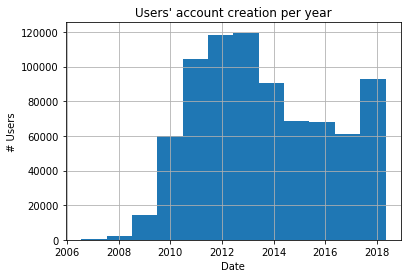

In [19]:
ax = users.created_at.hist(bins=12)
ax.set_xlabel('Date')
ax.set_ylabel('# Users')
ax.set_title("Users' account creation per year")

Text(0.5,1,"Users' account creation per month")

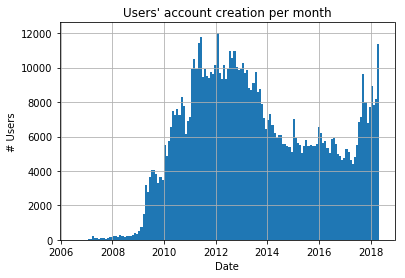

In [20]:
ax = users.created_at.hist(bins=144)
ax.set_xlabel('Date')
ax.set_ylabel('# Users')
ax.set_title("Users' account creation per month")

Text(0.5,1,"Users' account creation per day")

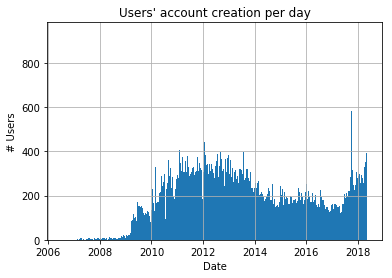

In [21]:
ax = users.created_at.hist(bins=4380)
ax.set_xlabel('Date')
ax.set_ylabel('# Users')
ax.set_title("Users' account creation per day")

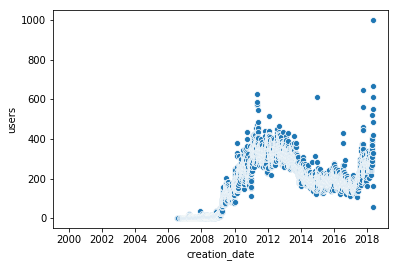

In [22]:
# 27-April - 4 May
users.loc[:,'creation_date'] = users.created_at.dt.date
tmp = users.groupby(['creation_date']).size().reset_index()
tmp.rename(columns={0:'users'},inplace=True)
ax=sns.scatterplot(data=tmp, x='creation_date', y='users')

<h3>User's # Favorites (in general)</h3>

Text(0.5,1,"Users' Favorite counts")

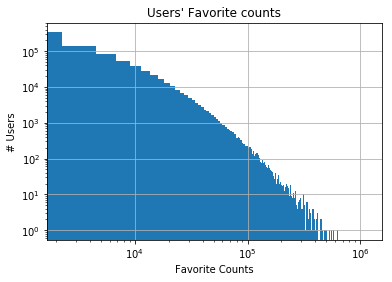

In [23]:
ax = users.favourites_count.hist(bins=500)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Favorite Counts')
ax.set_ylabel('# Users')
ax.set_title("Users' Favorite counts")

<h3>User's listed count</h3>
Around 1M users have been listed in $\leq$ 100 lists. <br />
Only a few users (~10) have been listed in at least 2K lists.

Text(0.5,1,"Users' Lists counts")

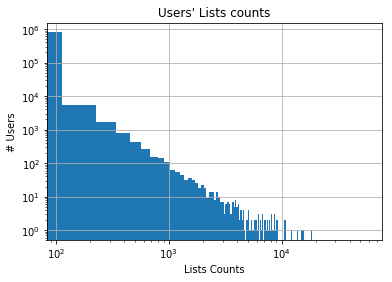

In [24]:
ax = users.listed_count.hist(bins=500)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Lists Counts')
ax.set_ylabel('# Users')
ax.set_title("Users' Lists counts")

<h3>#Friends vs #Followers</h3>
Verified accounts (right columns) tend to have more followers and a few friends compared to non-verified accounts <br />
This makes sense, since verified users are usually famous people such as celebrities, politicians, etc. Therefore, they have more followers than 'normal' users. <br />
There is no significant different between users with geo_enabled 0 or 1.